# Credit Scoring - Curso do Alura
- **Plataforma do curso**: Alura
- **Instrutora**: Karol Penteado
- **Data Info**: Statlog (German Credit Data) DataSet
- **Data [link](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))**

## Modelagem
- O Credit Scoring é um modelo estatístico multivariado que cria um modelo matemático e estima, através de uma probabilidade, a chance do nosso cliente ser adimplente ou inadimplente

```python
----------------------------------------
| cliente --> banco --> credit scoring |
----------------------------------------
```

- Existem alguns algoritmos que são capazes de fazer essa classificação, por exemplo: a regressão logística, o random forest, Naive Bayes, support vector machine.

- A princípio, vamos começar aplicando o modelo de classificação, **regressão logística**. 

- A **regressão logística** consiste em uma técnica muito usada no sistema financeiro. 

- Este modelo possui um alto comprometimento com a explicabilidade. Nós conseguimos acompanhar muito bem as variáveis ao longo do tempo, conseguimos replicar muito bem esse modelo e isso é bom para fins de fiscalização, além do baixo custo computacional.

- No sistema financeiro nós não analisamos **o indivíduo**.

- A análise é direcionada para o comportamento de um grupo, portanto, ajustamos o indivíduo dentro de um dos grupos


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve


### 1. Abrindo a base de dados e fazendo uma breve exploração

In [2]:
url = 'https://raw.githubusercontent.com/alura-cursos/credit_scoring/main/base_dados_traduzida.csv'
df = pd.read_csv(url)
df.head()

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,...,anos_residencia_atual,propriedade,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [4]:
df.info()
print(f'A base de dados tem {df.shape[0]} linhas e {df.shape[1]} colunas.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   default                      1000 non-null   int64 
 1   conta_corrente               1000 non-null   object
 2   prazo_emprestimo_meses       1000 non-null   int64 
 3   historico_credito            1000 non-null   object
 4   proposito_emprestimo         1000 non-null   object
 5   valor_emprestimo             1000 non-null   int64 
 6   reserva_cc                   1000 non-null   object
 7   tempo_emprego_atual          1000 non-null   object
 8   taxa_comp_salario            1000 non-null   int64 
 9   sexo_est_civil               1000 non-null   object
 10  outros_fiadores              1000 non-null   object
 11  anos_residencia_atual        1000 non-null   int64 
 12  propriedade                  1000 non-null   object
 13  idade                        1000 

In [6]:
# checando se temos dados duplicados
duplicate = df.duplicated()
duplicate = duplicate.sum()

print(f'A base tem {duplicate} dados duplicados.')

A base tem 0 dados duplicados.


In [7]:
# checando se temos valores nulos
df.isnull().sum()

default                        0
conta_corrente                 0
prazo_emprestimo_meses         0
historico_credito              0
proposito_emprestimo           0
valor_emprestimo               0
reserva_cc                     0
tempo_emprego_atual            0
taxa_comp_salario              0
sexo_est_civil                 0
outros_fiadores                0
anos_residencia_atual          0
propriedade                    0
idade                          0
outros_planos_financiamento    0
tipo_residencia                0
n_creditos_banco               0
status_emprego                 0
n_dependentes                  0
telefone                       0
trabalhador_estrangeiro        0
dtype: int64

## 2. Separando as variáveis da base
- X: características dos clientes
- y: classificação do score

Aqui nós podemos observar que a variável `default` é binária e que as demais estão divididas entre categóricas, como a variável `conta_corrente`, e variáveis numéricas discretas, como a `prazo_emprestimo_meses`, por exemplo, que traz, para cada linha, um valor discreto diferente.


In [29]:
def separando_train_test(df):
    """ A variável a ser predita, y, é chamada de `default`."""

    # Separando X e y
    X = df.drop('default', axis=1).loc[:, :]
    print(f'O tamanho de X é {X.shape}')
    y = df['default']
    print(f'O tamanho de X é {y.shape}')

    # separando os dados de treino e teste, em 70% para treino e 30% para teste
    SEED = 77 # definimos o seed para que este mesmo split seja replicado sem aleatoriedade
    treino_x, teste_x, treino_y, teste_y = train_test_split(X, y, test_size=0.3, random_state=SEED)
    print(f'A base de treino possui {treino_x.shape[0]} e de teste {teste_x.shape[0]}')

    return treino_x, teste_x, treino_y, teste_y

## 3. Tratando os dados: passando categóricos para numéricos
- Explorando com info(), temos as seguintes colunas categóricas:
```python

 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 

 1   conta_corrente               1000 non-null   object
 3   historico_credito            1000 non-null   object
 4   proposito_emprestimo         1000 non-null   object
 6   reserva_cc                   1000 non-null   object
 7   tempo_emprego_atual          1000 non-null   object
 9   sexo_est_civil               1000 non-null   object
 10  outros_fiadores              1000 non-null   object
 12  propriedade                  1000 non-null   object
 14  outros_planos_financiamento  1000 non-null   object
 15  tipo_residencia              1000 non-null   object
 17  status_emprego               1000 non-null   object
 19  telefone                     1000 non-null   object
 20  trabalhador_estrangeiro      1000 non-null   object
 ```

In [16]:
cc_var = list(df['conta_corrente'].unique())
cc_var

['< 0 DM',
 '0 <= ... < 200 DM',
 'no checking account',
 '>= 200 DM / salary assignments for at least 1 year']

In [21]:
cc_dict = {}
for i, cc in enumerate(cc_var):
    cc_dict[cc] = i+1

cc_dict


{'< 0 DM': 1,
 '0 <= ... < 200 DM': 2,
 'no checking account': 3,
 '>= 200 DM / salary assignments for at least 1 year': 4}

In [22]:
# transformando as strings das caterogias de `conta corrente` para valores numéricos
df['conta_corrente'] = df['conta_corrente'].map(cc_dict)
df['conta_corrente'].unique()

array([1, 2, 3, 4], dtype=int64)

- **Criando uma função para passar os dados `categóricos` para `numéricos`:**

In [23]:
def passa_categorico_para_numerico(df:pd.DataFrame, coluna:str):
    """
    Esta função recebe um DataFrame e sua coluna categórica (string) 
    que será convertida para numérica.
    
    Retorna: o próprio DataFrame com a coluna já ajustada.
    """
    v_list = list(df[coluna].unique())
    v_dict = {}
    for i, v in enumerate(v_list):
        v_dict[v] = i+1
    df[coluna] = df[coluna].map(v_dict)
    return df

In [26]:
df.head(2)

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,...,anos_residencia_atual,propriedade,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro
0,0,1,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,2,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes


In [27]:
# Ajustando as demais colunas da base da dados
dados_categoricos =  """historico_credito
                        proposito_emprestimo
                        reserva_cc 
                        tempo_emprego_atual
                        sexo_est_civil   
                        outros_fiadores  
                        propriedade     
                        outros_planos_financiamento  
                        tipo_residencia     
                        status_emprego  
                        telefone
                        trabalhador_estrangeiro"""

dados_categoricos = dados_categoricos.split()
for coluna in dados_categoricos:
    df = passa_categorico_para_numerico(df, coluna)

df.head()

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,...,anos_residencia_atual,propriedade,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro
0,0,1,6,1,1,1169,1,1,4,1,...,4,1,67,1,1,2,1,1,1,1
1,1,2,48,2,1,5951,2,2,2,2,...,2,1,22,1,1,1,1,1,2,1
2,0,3,12,1,2,2096,2,3,2,1,...,3,1,49,1,1,1,2,2,2,1
3,0,1,42,2,3,7882,2,3,2,1,...,4,2,45,1,2,1,1,2,2,1
4,1,1,24,3,4,4870,2,2,3,1,...,4,3,53,1,2,2,1,2,2,1


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   default                      1000 non-null   int64
 1   conta_corrente               1000 non-null   int64
 2   prazo_emprestimo_meses       1000 non-null   int64
 3   historico_credito            1000 non-null   int64
 4   proposito_emprestimo         1000 non-null   int64
 5   valor_emprestimo             1000 non-null   int64
 6   reserva_cc                   1000 non-null   int64
 7   tempo_emprego_atual          1000 non-null   int64
 8   taxa_comp_salario            1000 non-null   int64
 9   sexo_est_civil               1000 non-null   int64
 10  outros_fiadores              1000 non-null   int64
 11  anos_residencia_atual        1000 non-null   int64
 12  propriedade                  1000 non-null   int64
 13  idade                        1000 non-null   int6

- **SEPARANDO A BASE EM X e y:**

In [30]:
treino_x, teste_x, treino_y, teste_y = separando_train_test(df)

O tamanho de X é (1000, 20)
O tamanho de X é (1000,)
A base de treino possui 700 e de teste 300


## 4. Modelagem: `REGRESSÃO LOGÍSTICA`
- Iniciando o ajuste dos dados no modelo de forma simples e verificando a acurácia:

In [32]:
model = LogisticRegression(max_iter=1000)
model.fit(treino_x, treino_y)
score = model.score(treino_x, treino_y)

print(f'acurácia: {score:.2f}')

acurácia: 0.75


- **Verificando as métricas (individualmente) do modelo:**

In [39]:
predito_y = model.predict(teste_x)
acuracia = accuracy_score(teste_y, predito_y)
f1 = f1_score(teste_y, predito_y)
recall = recall_score(teste_y, predito_y)
auc_score = roc_auc_score (teste_y, predito_y)

print(f'Acurácia: {acuracia*100:2f}%')
print(f'F1: {f1*100:2f}%')
print(f'Recall: {recall*100:2f}%')
print(f'Area Under the Curve: {auc_score*100:2f}%')

Acurácia: 77.333333%
F1: 54.054054%
Recall: 46.511628%
Area Under the Curve: 68.115627%


c:\Users\ananda.coelho\Anaconda3\envs\inadimplencia\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


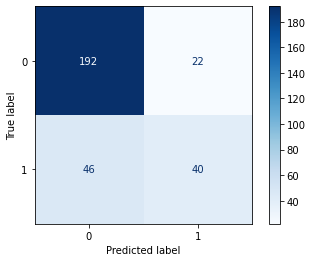

In [42]:
# matriz de confusão para verificarmos como o modelo está performando com FP e FN
mc = plot_confusion_matrix(model, teste_x, teste_y, cmap='Blues', values_format='.3g')

**Podemos observar que o modelo consegue identificar bem os labels = 0. Mas erra muito os labels = 1**
- True positives (era 0 e o modelo acertou que era 0): cliente que paga bem, não é inadimplente
- False positive (era 1 e o modelo chutou 0): o modelo diz que é um bom pagados mas não é, o cliente é inadimplente
- False negative (era 0 mas o modelo chutou 1): o cliente é um bom pagador mas o modelo classificou como inadimplente
- True negative (era 1 e o modelo acertou como 1): classificou o cliente inadimplente corretamente

**MÉTRICAS DERIVADAS DA MATRIZ DE CONFUSÃO**
1. Precisão: Proporção de predições corretas de uma categoria em relação a todas as predições desta categoria.

    $Precisão$ = $VP / (VP + FP)$

2. Recall: Proporção de predições corretas de categoria alvo.

    $Recall$ = $VP / (VP + FN)$

3. F1-Score: Média harmônica entre precisão e recall.

    $F1 - score$ = $2 * (Precisão * Recall) / (Precisão + Recall)$

4. support: é a quantidade absoluta de casos encontrados em cada categoria


In [46]:
print(classification_report(teste_y, predito_y))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       214
           1       0.65      0.47      0.54        86

    accuracy                           0.77       300
   macro avg       0.73      0.68      0.70       300
weighted avg       0.76      0.77      0.76       300



In [49]:
predito_y_prob = model.predict_proba(teste_x)[: ,1]

# taxa de falsos positivos = tfp
# taxa de verdadeiros positivos = tvp

tfp, tvp, limit = roc_curve(teste_y, predito_y_prob)
print(f'area under the curve: {roc_auc_score(teste_y, predito_y_prob):.2f}')

area under the curve: 0.76


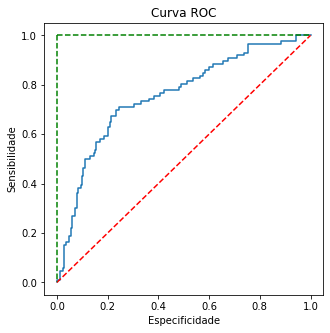

In [50]:
plt.subplots(1, figsize=(5,5))
plt.title('Curva ROC')
plt.plot(tfp, tvp)
plt.plot([0, 1], ls="--", c = 'red') #plotando linha pontilhada guia para regressao aleatoria
plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha pontilhada guia para regressao perfeita
plt.ylabel('Sensibilidade')
plt.xlabel('Especificidade')
plt.show()

$Especificidade = VN / (VN + FP)$
-  Já a especificidade mede a taxa em que a categoria 0 foi, de maneira errada, classificada como 1

$Sensibilidade = VP (VP + FN)$
- A sensibilidade indica a taxa de casos em que a categoria alvo, ou seja, a categoria 1, foi classificada corretamente.

- **Objetivo: maximizar a `taxa de verdadeiros positivos` e vai minimizar a minha `taxa de falsos positivos`. buscamos esse trade-off, nós queremos maximizar um enquanto minimizamos o outro consequentemente**

- Quantifica a Curva ROC através da área sob esta curva

    - Convenção Estatística:

       - área < 0,7: baixa discriminiação
       - 0,7 ≤ área < 0,8: discriminação aceitável
       - 0,8 ≤ área < 0,9: discriminação excelente
       - área > 0,9: discriminação excepcional

In [51]:
print(f'Com a métrica ROC de {roc_auc_score(teste_y, predito_y_prob):.2f}, temos uma discriminação aceitável.')

Com a métrica ROC de 0.76, temos uma discriminação aceitável.


#### 4.1 Análise Descritiva

In [54]:
variaveis_analise = ['idade', 'prazo_emprestimo_meses', 'valor_emprestimo', 'taxa_comp_salario', 'anos_residencia_atual', 'n_creditos_banco', 'n_dependentes']
df[variaveis_analise].describe()

,idade,prazo_emprestimo_meses,valor_emprestimo,taxa_comp_salario,anos_residencia_atual,n_creditos_banco,n_dependentes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000,2.973000,2.845000,1.407000,1.155000
std,11.375469,12.058814,2822.736876,1.118715,1.103718,0.577654,0.362086
min,19.000000,4.000000,250.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000
50%,33.000000,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000
75%,42.000000,24.000000,3972.250000,4.000000,4.000000,2.000000,1.000000
max,75.000000,72.000000,18424.000000,4.000000,4.000000,4.000000,2.000000


**Analisando a Variável `sexo_est_civil`:**
- Homem: 1,3,4
- Mulher: 2

In [57]:
pd.DataFrame(df['sexo_est_civil'].value_counts()).rename(index={1:'H', 3:'H', 4:'H', 2:'M'})

,sexo_est_civil
H,548
M,310
H,92
H,50


In [60]:
pd.DataFrame(df['sexo_est_civil'].value_counts()).rename(index={1:'H', 3:'H', 4:'H', 2:'M'}).reset_index().groupby('index').sum()

,sexo_est_civil
index,
H,690
M,310


In [58]:
pd.DataFrame(df['default'].value_counts()).rename(index={0:'negado',1:'concedido'})

,default
negado,700
concedido,300


- **Avaliando as distribuições das variáveis:**

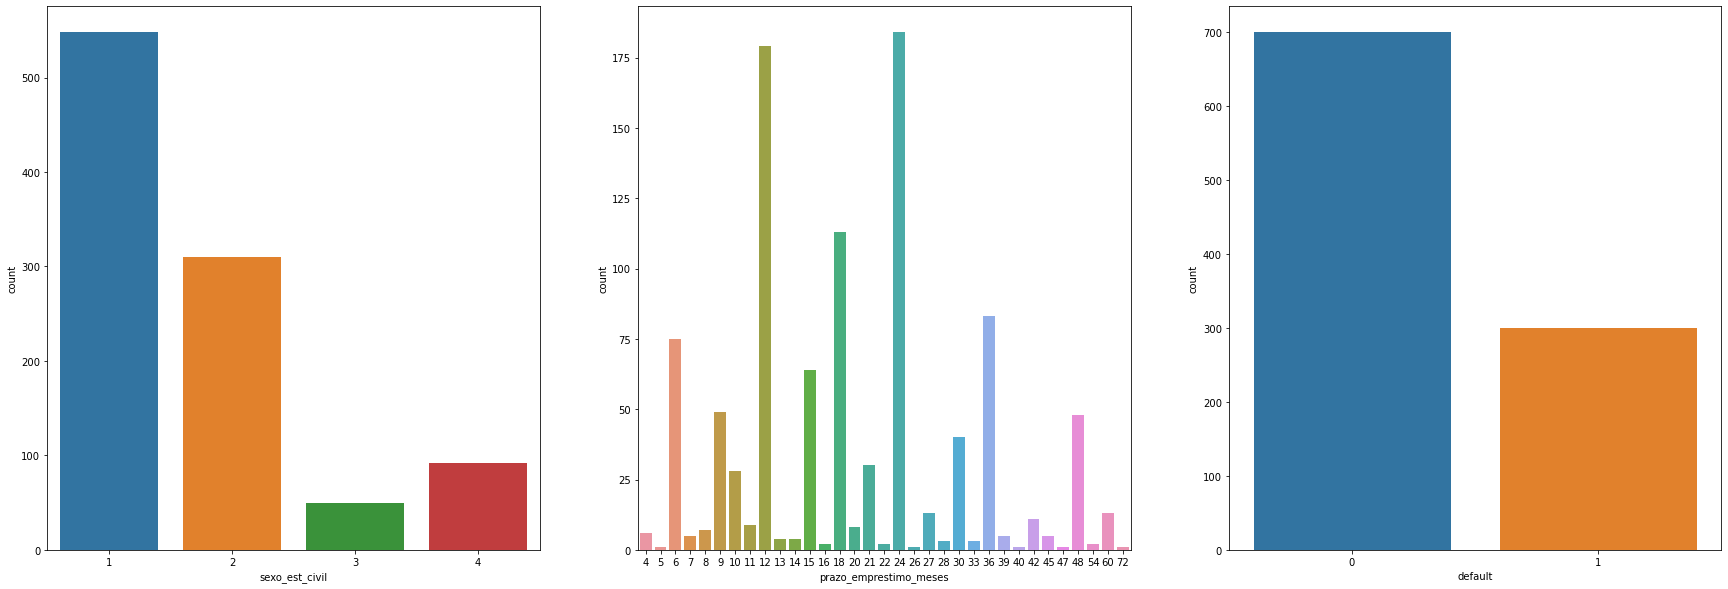

In [65]:
hist = ['sexo_est_civil','prazo_emprestimo_meses','default']
# criando tuplas das colunas de histograma 
hist = list(enumerate(hist))
# plotando todas as colunas
plt.figure(figsize=(30,10))
plt.title('CONTAGEM DE CADA LABEL')
for i in hist: 
    plt.subplot(1,3, i[0]+1)
    sns.countplot(x=i[1], data=df)

Trabalhando com os histogramas, podemos ver a frequencia das variáveis.
Essa frequência pode ser absoluta, pode ser relativa, pode ser uma densidade, mas ele vai me mostrar os dados de forma quantitativa

- **Claramente, Temos uma base desbalanceada**

Text(0.5, 1.0, 'DISTRIBUIÇÃO DE IDADE POR SEXO E ESTADO CIVIL')

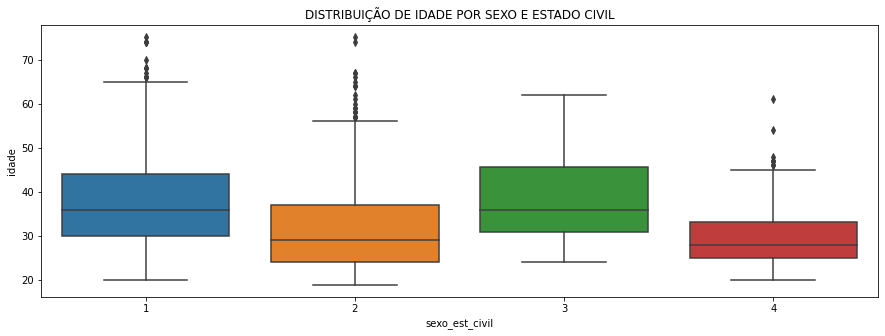

In [67]:
plt.figure(figsize=(15,5))

sns.boxplot(x='sexo_est_civil', y='idade', data=df)

plt.title("DISTRIBUIÇÃO DE IDADE POR SEXO E ESTADO CIVIL")

O boxplot é um excelente gráfico estatístico, com ele podemos identificar de cara alguns parâmetros:
- a linha central é a mediana
- temos o menor e o maior valor
- o primeiro e o terceiro quartil
- e também podemos ver valores discrepantes (outliers)



c:\Users\ananda.coelho\Anaconda3\envs\inadimplencia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


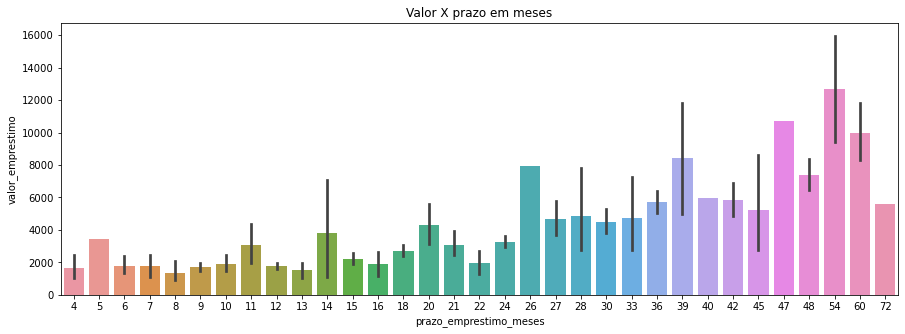

In [74]:
plt.figure(figsize=(15,5))

sns.barplot(df.prazo_emprestimo_meses, df.valor_emprestimo)

plt.xlabel('prazo_emprestimo_meses')
plt.ylabel('valor_emprestimo')
plt.title('Valor X prazo em meses')

plt.show()

O gráfico de barra facilita aqui a comparação entre categorias, mostranod a distribuição de uma delas. 

Essa distribuição pode ser absoluta ou percentual, relativa a alguma coisa

Em problemas de classificação vão existir casos onde podemos ter que trabalhar com bases de dados não balanceadas. Ou seja, bases de dados com um número pequeno de exemplos de uma classe em relação às demais classes. Isto pode ocorrer devido a características do problema, a forma como os dados foram coletados ou erros durante a coleta. A presença de um número de exemplos diferentes em cada uma das classes do problema é comum. Porém, devemos nos preocupar quando essa diferença se torna muito grande.

Um dos problemas que podemos ter quando trabalhamos com dados não balanceados está na acurácia. Se tivermos 80% de exemplos de clientes que não obtiveram concessão de crédito como exemplo e 20% que obtiveram crédito podemos ter uma acurácia de 80%. Entretanto, o modelo pode estar acertando 80% das vezes simplesmente porque “percebeu” que escolhendo a classe 1 para todas as tentativas teria uma porcentagem maior de acerto.

Para lidar com este tipo de problema existem algumas técnicas. Uma delas é a que estamos adotando no curso que é a utilização de outras métricas, como a matriz de confusão, precisão, recall, o F1 Score e a curva ROC. Essas nos permitem entender melhor o que está acontecendo com o modelo.

Outra estratégia é a reamostragem dos dados. Caso a base de dados seja grande o suficiente é possível dividi-la desconsiderando os exemplos em excesso de uma das classes. Em alguns casos também é possível testar a sobreamostragem. Na sobreamostragem são adicionadas cópias de exemplos da classe que está pouco representada na base de dados. Ainda em relação aos dados é possível gerar exemplos sintéticos. Para esse objetivo existem algoritmos que realizam uma amostragem randômica dos atributos dos exemplos da classe pouco representada na base de dados.

Trabalhar o que o modelo pode fazer também é uma opção. Alguns algoritmos conseguem impor uma penalização ao modelo durante o treino. Assim, ele irá prestar mais atenção na classe com menos exemplos.

### 4.2 No Brasil, o Banco Central considera uma informação sensível:
- Origem social e étnica
- condições de saúde
- informação genética
- orientação sexual
- convicções políticas, religiosas e filosóficas.

#### **Portanto, precisamos remover essas informações do nosso dataset (que é de origem alemã, e neste país existem outras regras relacionadas às informações)**

In [76]:
## 1 = mulher
## 0 = homem
dict_sexo = {2:1, 5:1, 1:0, 3:0, 4:0}

## 1 = solteira
## 0 = casada/divorciada/viúva
dict_est_civil = {3:1, 5:1, 1:0, 2:0, 4:0}

df['estado_civil'] = df['sexo_est_civil'].map(dict_est_civil)
df['sexo'] = df['sexo_est_civil'].map(dict_sexo)

df.head() 

,default,conta_corrente,prazo_emprestimo_meses,historico_credito,proposito_emprestimo,valor_emprestimo,reserva_cc,tempo_emprego_atual,taxa_comp_salario,sexo_est_civil,...,idade,outros_planos_financiamento,tipo_residencia,n_creditos_banco,status_emprego,n_dependentes,telefone,trabalhador_estrangeiro,estado_civil,sexo
0,0,1,6,1,1,1169,1,1,4,1,...,67,1,1,2,1,1,1,1,0,0
1,1,2,48,2,1,5951,2,2,2,2,...,22,1,1,1,1,1,2,1,0,1
2,0,3,12,1,2,2096,2,3,2,1,...,49,1,1,1,2,2,2,1,0,0
3,0,1,42,2,3,7882,2,3,2,1,...,45,1,2,1,1,2,2,1,0,0
4,1,1,24,3,4,4870,2,2,3,1,...,53,1,2,2,1,2,2,1,0,0


#### 4.3 Criação de uma função: automação e novos testes

In [102]:
def treina_modelo(df, classificador):
    print(f'A base de dados tem {df.shape[0]} linhas e {df.shape[1]} colunas.')
    # separando os dados em treino e teste
    treino_x, teste_x, treino_y, teste_y = separando_train_test(df)
    # instanciando o modelo
    model = classificador
    model.fit(treino_x, treino_y)
    print('-'*100)
    # métricas do modelo
    print(classification_report(teste_y, predito_y))
    print('-'*100)
    predito_y_prob = model.predict_proba(teste_x)[: ,1]
    tfp, tvp, limit = roc_curve(teste_y, predito_y_prob)
    print(f'area under the curve: {roc_auc_score(teste_y, predito_y_prob):.2f}')
    # plt.subplots(1,2, figsize=(5,5))
    # plt.subplot(1, 2, 1)
    # matriz de confusão para verificarmos como o modelo está performando com FP e FN
    mc = plot_confusion_matrix(model, teste_x, teste_y, cmap='Blues', values_format='.3g')
    # plt.show()
    # plt.subplot(1,2,2)
    plt.subplots(figsize=(5,5))
    plt.title('Curva ROC')
    plt.plot(tfp, tvp)
    plt.plot([0, 1], ls="--", c = 'red') #plotando linha pontilhada guia para regressao aleatoria
    plt.plot([0, 0], [1, 0], ls="--", c = 'green'), plt.plot([1, 1], ls="--", c = 'green') #plotando linha pontilhada guia para regressao perfeita
    plt.ylabel('Sensibilidade')
    plt.xlabel('Especificidade')
    plt.show()
    
    return model, mc

In [103]:
base_dados = df.drop(['sexo','sexo_est_civil'], axis=1)

A base de dados tem 1000 linhas e 21 colunas.
O tamanho de X é (1000, 20)
O tamanho de X é (1000,)
A base de treino possui 700 e de teste 300
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       214
           1       0.65      0.47      0.54        86

    accuracy                           0.77       300
   macro avg       0.73      0.68      0.70       300
weighted avg       0.76      0.77      0.76       300

----------------------------------------------------------------------------------------------------
area under the curve: 0.76


c:\Users\ananda.coelho\Anaconda3\envs\inadimplencia\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


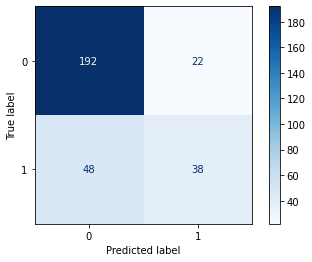

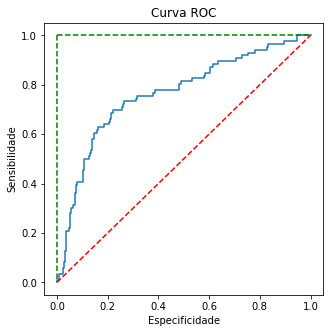

In [104]:
model, mc = treina_modelo(base_dados, LogisticRegression(max_iter=1000))

#### 4.4 Cross-validation
- Vamos aplicar essa técnica para saber quão bem o modelo está conseguindo generalizar a resposta para os dados

- `K-fold`: dividimos a base `K` vezes, realizar o treino com a maior parte destas amostras e depois testar a última parte

![Imagem](https://caelum-online-public.s3.amazonaws.com/2124-ml-credit-score/02/imagem-parasabermais-aula2)

***
***